In [13]:
import yfinance as yf
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model


    

In [25]:
#get data for sp500 index stored in a pandas dataframe
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period="max")

In [27]:
#remove dividends and stock splits since we are not using it
if "Dividends" in sp500.columns:
    del sp500["Dividends"]

if "Stock Splits" in sp500.columns:
    del sp500["Stock Splits"]

# Display the resulting DataFrame
sp500

,Open,High,Low,Close,Volume
Date,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0
...,...,...,...,...,...
2025-02-05 00:00:00-05:00,6020.450195,6062.859863,6007.060059,6061.479980,4756250000
2025-02-06 00:00:00-05:00,6072.220215,6084.029785,6046.830078,6083.569824,4847120000
2025-02-07 00:00:00-05:00,6083.129883,6101.279785,6019.959961,6025.990234,4766900000


<Axes: xlabel='Date'>

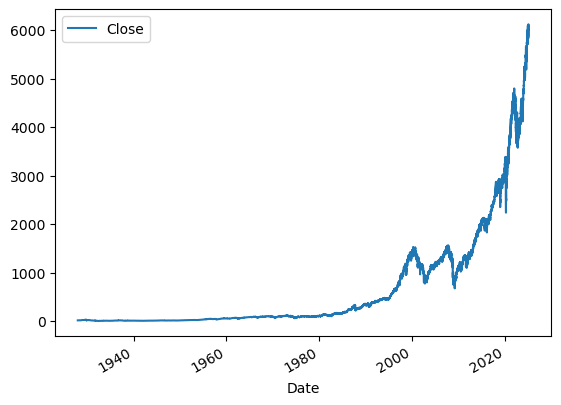

In [29]:
#generate the trend plot for the sp500 from 1927 - current
sp500.plot.line(y="Close",use_index=True)

In [33]:
#create 2 more columns with Tomorrow being expected price based on trend
#Target returns 1 "true" if tomorrow price is greater than current closing price
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)


In [6]:
#Remove old data, focusing on more recent data from 1999
sp500 = sp500.loc["1999-01-01":].copy()
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1999-01-04 00:00:00-05:00,1229.229980,1248.810059,1219.099976,1228.099976,877000000,1244.780029,1
1999-01-05 00:00:00-05:00,1228.099976,1246.109985,1228.099976,1244.780029,775000000,1272.339966,1
1999-01-06 00:00:00-05:00,1244.780029,1272.500000,1244.780029,1272.339966,986900000,1269.729980,0
1999-01-07 00:00:00-05:00,1272.339966,1272.339966,1257.680054,1269.729980,863000000,1275.089966,1
1999-01-08 00:00:00-05:00,1269.729980,1278.239990,1261.819946,1275.089966,937800000,1263.880005,0
...,...,...,...,...,...,...,...
2025-02-03 00:00:00-05:00,5969.649902,6022.129883,5923.930176,5994.569824,4797210000,6037.879883,1
2025-02-04 00:00:00-05:00,5998.140137,6042.479980,5990.870117,6037.879883,4410160000,6061.479980,1
2025-02-05 00:00:00-05:00,6020.450195,6062.859863,6007.060059,6061.479980,4756250000,6083.569824,1


In [7]:
#Train initial model using Random Forest
#Random forest reduce the chances of overfitting
#Random forest will create a bunch of decision trees and find avg

model = RandomForestClassifier(n_estimators=500, min_samples_split=50, random_state=1)
train = sp500.iloc[:-100]
test = sp500.iloc[-100:]
predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])
                              

RandomForestClassifier(min_samples_split=50, n_estimators=500, random_state=1)

In [8]:
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"],preds)

1.0

<Axes: xlabel='Date'>

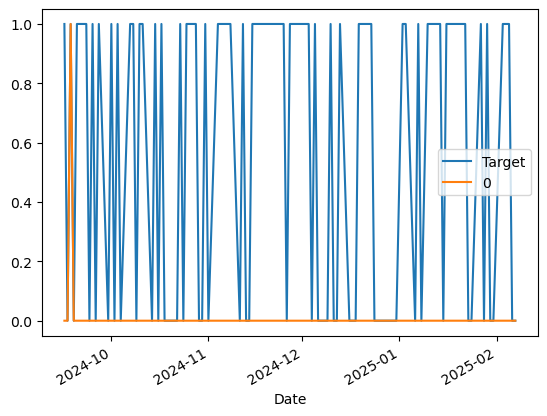

In [9]:
combined = pd.concat([test["Target"], preds], axis = 1)
combined.plot()

In [10]:
#backtesting
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis = 1)
    return combined

def backtest(data, model, predictors, start = 2500, step=250):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [13]:
new_predictors = ["Open", "High", "Low", "Close", "Volume"]

predictions = backtest(sp500, model, new_predictors)


In [14]:
predictions["Predictions"].value_counts()

Predictions
0.0    3393
1.0     673
Name: count, dtype: int64

In [15]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5215453194650818

In [16]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.545499
0    0.454501
Name: count, dtype: float64

In [17]:
horizons = [2, 5, 60, 250, 1000]
new_predictors = []
for horizon in horizons:
    rolling_avg = sp500.rolling(horizon).mean()
    ratio_col = f"Close_Ratio_{horizon}"
    sp500[ratio_col] = sp500["Close"] / rolling_avg["Close"]
    trend_col = f"Trend_{horizon}"
    sp500[trend_col] = sp500["Target"].shift(1).rolling(horizon).sum()
    new_predictors += [ratio_col, trend_col]


In [ ]:
sp500

AttributeError: 'NoneType' object has no attribute 'save'

In [112]:
# Function to fetch stock data
def get_stock_data(ticker, start="2000-01-01", end="2025-01-01"):
    data = yf.download(ticker, start=start, end=end)
    return data[['Close']]

# Load S&P 500 data
sp500_data = get_stock_data("^GSPC")

# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
sp500_scaled = scaler.fit_transform(sp500_data)

# Prepare training data
def prepare_data(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

time_step = 60
X, y = prepare_data(sp500_scaled)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM

# Split into training and testing
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

model.save("stock_lstm_model.h5")
print("Model saved successfully!")


[*********************100%***********************]  1 of 1 completed
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0035 - val_loss: 0.0017
Epoch 2/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 2.8597e-04 - val_loss: 8.2070e-04
Epoch 3/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.8923e-04 - val_loss: 4.5752e-04
Epoch 4/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.7258e-04 - val_loss: 5.3936e-04
Epoch 5/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.5327e-04 - val_loss: 7.2466e-04
Epoch 6/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.4231e-04 - val_loss: 3.7423e-04
Epoch 7/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.3697e-04 - val_loss: 3.2849e-04
Epoch 8/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.6986e-04 - val_loss: 8.2406e-04
Epoch 9/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 1.3079e-04 - val_loss: 3.0911e-04
Epoch 10/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.2147e-04 - val_loss: 4.3120e-04
Epoch 11/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - l

Model saved successfully!


In [ ]:
#Training/Testing validation
# Train the model and store history
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Save the trained model
model.save("stock_lstm_model.h5")
print("Model saved successfully!")

# Plot Loss Graph (Training & Validation)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label="Training Loss", color='blue')
plt.plot(history.history['val_loss'], label="Validation Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# If accuracy exists, plot accuracy graph
if 'accuracy' in history.history:
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label="Training Accuracy", color='blue')
    plt.plot(history.history['val_accuracy'], label="Validation Accuracy", color='red')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy Over Epochs")
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("Accuracy metric not found. If needed, modify model.compile() to include metrics=['accuracy'].")


In [85]:
# Function to plot investment growth
def plot_investment_growth(initial_investment, start_year, ticker):
    start_date = f"{start_year}-01-01"
    end_date = "2024-01-01"
    data = get_stock_data(ticker, start_date, end_date)
    
    if data.empty:
        print("No data available for this period.")
        return

    shares_bought = initial_investment / data.iloc[0]['Close']
    data['Investment Value'] = shares_bought * data['Close']

    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Investment Value'], label="Investment Value")
    plt.xlabel("Year")
    plt.ylabel("Value ($)")
    plt.title(f"Growth of ${initial_investment} Investment in {ticker} since {start_year}")
    plt.legend()
    plt.show()    

[*********************100%***********************]  1 of 1 completed
/var/folders/30/9fv2b9ms2gs4g886pqrhh3x80000gn/T/ipykernel_39268/3797444485.py:35: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  initial_price = float(data.iloc[0]['Close'])  # Convert to float
/var/folders/30/9fv2b9ms2gs4g886pqrhh3x80000gn/T/ipykernel_39268/3797444485.py:36: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(data.iloc[-1]['Close'])  # Convert to float
[*********************100%***********************]  1 of 1 completed


Initial Price in 2000: $0.09
Current Price: $134.29
Estimated Value of Investment in NVDA: $7,507,294.95


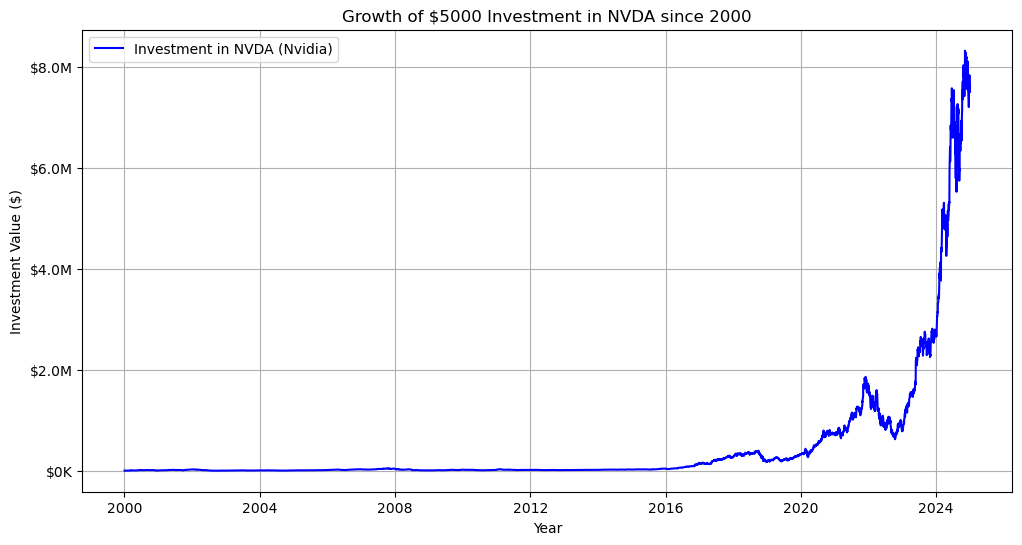

In [91]:
# Dictionary of common stock tickers with company names
stock_ticker_legend = {
    "NVDA": "Nvidia",
    "AAPL": "Apple",
    "TSLA": "Tesla",
    "GOOGL": "Alphabet (Google)",
    "AMZN": "Amazon",
    "MSFT": "Microsoft",
    "META": "Meta (Facebook)",
    "NFLX": "Netflix",
    "AMD": "Advanced Micro Devices",
    "BRK-A": "Berkshire Hathaway",
    "V": "Visa",
    "JPM": "JPMorgan Chase",
}

# Function to fetch stock data from 2000 - 2025
def get_stock_data(ticker, start="2000-01-01", end="2025-01-01"):
    data = yf.download(ticker, start=start, end=end)
    return data[['Close']] if not data.empty else None

# Function to estimate investment value from start year to current
def estimate_investment(initial_investment, start_year, ticker):
    # Fetch data from start_year to today
    start_date = f"{start_year}-01-01"
    end_date = "2025-01-01"
    data = get_stock_data(ticker, start_date, end_date)
    
    if data is None:
        return "No data available for this period."

    initial_price = float(data.iloc[0]['Close'])  # Convert to float
    current_price = float(data.iloc[-1]['Close'])  # Convert to float

    final_value = (initial_investment / initial_price) * current_price

    return initial_price, current_price, final_value

#function to plot investment growth for estinmated investment
def plot_investment_growth(initial_investment, start_year, ticker):
    start_date = f"{start_year}-01-01"
    end_date = "2025-01-01"
    data = get_stock_data(ticker, start_date, end_date)

    if data is None:
        print("No data available for this period.")
        return

    shares_bought = initial_investment / data.iloc[0]['Close']
    data['Investment Value'] = shares_bought * data['Close']

    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Investment Value'], label=f"Investment in {ticker} ({stock_ticker_legend.get(ticker, ticker)})", color="b")

    plt.xlabel("Year")
    plt.ylabel("Investment Value ($)")
    plt.title(f"Growth of ${initial_investment} Investment in {ticker} since {start_year}")
    plt.legend()
    plt.grid()
    ax = plt.gca()
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"${x/1000:,.0f}K" if x < 1_000_000 else f"${x/1_000_000:,.1f}M"))

    plt.show()

# Example Usage
initial_investment = 5000
start_year = 2000
ticker = "NVDA"

initial_price, current_price, estimated_value = estimate_investment(initial_investment, start_year, ticker)

print(f"Initial Price in {start_year}: ${initial_price:.2f}")
print(f"Current Price: ${current_price:.2f}")
print(f"Estimated Value of Investment in {ticker}: ${estimated_value:,.2f}")

# Plot investment growth
plot_investment_growth(initial_investment, start_year, ticker)


[*********************100%***********************]  1 of 1 completed


Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Predicted Stock Price in 2030: $243.87
Potential Earnings from $5000 Investment: $4874.49 (Profit: $-125.51)


/var/folders/30/9fv2b9ms2gs4g886pqrhh3x80000gn/T/ipykernel_39268/385685925.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  initial_price = float(data.iloc[-1]['Close'])


(243.86592, 4874.491726934961)

In [116]:
# Load the trained LSTM model
try:
    model = load_model("stock_lstm_model.h5")  # Ensure you have a saved model file
    print("LSTM Model Loaded Successfully!")
except:
    print("Model file not found. Please train and save the model as 'stock_lstm_model.h5'.")
    model = None


LSTM Model Loaded Successfully!


In [118]:
def get_stock_data(ticker, start="2000-01-01", end="2025-01-01"):
    data = yf.download(ticker, start=start, end=end)
    return data[['Close']] if not data.empty else None


In [120]:
def predict_future_stock(ticker, start="2000-01-01", future_year=2030, investment=5000):
    if model is None:
        print("Model not loaded. Unable to make predictions.")
        return None

    # Fetch stock data
    data = get_stock_data(ticker, start=start, end="2025-01-01")

    if data is None or data.empty:
        print(f"No stock data available for {ticker}.")
        return None  # Prevents unpacking error

    # Scale data
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(data)

    # Prepare input for prediction (last 60 days of data)
    time_step = 60
    last_sequence = scaled_data[-time_step:]
    last_sequence = np.reshape(last_sequence, (1, time_step, 1))

    # Predict future stock price
    predicted_scaled_price = model.predict(last_sequence)
    predicted_price = scaler.inverse_transform(predicted_scaled_price.reshape(-1, 1))[0][0]

    # Estimate potential earnings
    initial_price = float(data.iloc[-1]['Close'])
    shares_bought = investment / initial_price
    future_value = shares_bought * predicted_price
    profit = future_value - investment

    print(f"Predicted Stock Price in {future_year}: ${predicted_price:.2f}")
    print(f"Potential Earnings from ${investment} Investment: ${future_value:.2f} (Profit: ${profit:.2f})")

    return predicted_price, future_value  # Ensures values are returned


In [122]:
def plot_future_earnings(ticker, start="2000-01-01", future_year=2030, investment=5000):
    result = predict_future_stock(ticker, start, future_year, investment)
    
    if result is None:
        print("Unable to generate future earnings plot due to missing data or model error.")
        return
    
    predicted_price, future_value = result  # Unpack safely

    years = list(range(2025, future_year + 1))
    earnings = np.linspace(investment, future_value, len(years))

    plt.figure(figsize=(10, 5))
    plt.plot(years, earnings, marker='o', linestyle='-', color='b', label="Projected Earnings")
    plt.xlabel("Year")
    plt.ylabel("Investment Value ($)")
    plt.title(f"Projected Earnings for {ticker} Investment (${investment})")
    plt.legend()
    plt.grid()
    plt.show()


[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Predicted Stock Price in 2050: $132.51
Potential Earnings from $5000 Investment: $4933.90 (Profit: $-66.10)



/var/folders/30/9fv2b9ms2gs4g886pqrhh3x80000gn/T/ipykernel_39268/465284218.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  initial_price = float(data.iloc[-1]['Close'])


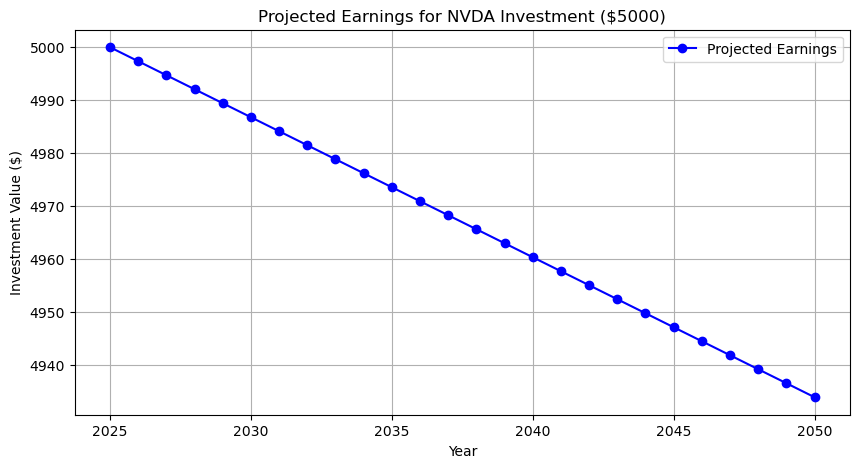

In [128]:
plot_future_earnings("NVDA", future_year=2050, investment=5000)
